In [2]:
from konlpy.tag import Okt
import codecs
import gensim
import time
import multiprocessing
import logging

In [2]:
Okt().pos("나는, 서울대학교 ~통계학과 !학생입니다.")  # [('오버', 'Noun'), ('워치', 'Noun')]

[('서울대학교', 'Noun'),
 ('~', 'Punctuation'),
 ('통계학', 'Noun'),
 ('과', 'Josa'),
 ('!', 'Punctuation'),
 ('학생', 'Noun'),
 ('입니다', 'Adjective'),
 ('.', 'Punctuation')]

In [4]:
okt = Okt() #Twitter의 형태소 처리기
corpus = codecs.open('corpus.txt', 'w', encoding='utf-8')

def flat(content):
    return ["{}/{}".format(word, tag) for word, tag in okt.pos(content)]

corpus.write(' '.join(flat("깜지는 강아지이고 귀엽다")) + '\n')

In [4]:
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [5]:
#토큰화 과정, 148분 걸렸음, there may be a faster way

def report(text, index):
    if index % int(len(text)*0.001) == 0:
        print('{}/{} ({}%) completed'.format(index,len(text), index / len(text) * 100))

def tokenize(line, index, tokenizer, report=None):
    if report:
        report(text, index) 
    return tokenizer.morphs(line)

t = time.time()

with open('text/wiki_data.txt', 'r') as f:
     text = f.readlines() #6010095줄
token = [tokenize(line, index, okt, report) for index, line in enumerate(text) if index<100]

print('Time to tokenize wikipedia text: {} mins'.format(round((time.time() - t) / 60, 2)))

0/6010095 (0.0%) completed
Time to tokenize wikipedia text: 0.07 mins


In [6]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [7]:
embedding = gensim.models.word2vec.Word2Vec(min_count=5, window=2, size=300, sample=6e-5,
                                            alpha=0.03, min_alpha=0.0007, negative=20,workers=cores-1)

In [8]:
t = time.time()

embedding.build_vocab(token, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [9]:
##training the model
t = time.time()

embedding.train(token, total_examples=embedding.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 0.01 mins


In [10]:
#As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

embedding.init_sims(replace=True)

embedding_name = 'kowiki_300size'
embedding.save(embedding_name)

In [16]:
print(embedding.wv.most_similar(positive=["공포"]))
print(embedding.wv.most_similar(positive=["동물"]))
print(embedding.wv.most_similar(positive=["통계"]))

[('제정', 0.4467240869998932), ('두려움', 0.4429143965244293), ('혐오', 0.4345221519470215), ('불안감', 0.4040243923664093), ('栱包', 0.402253657579422), ('증오', 0.38317736983299255), ('분노', 0.3810647130012512), ('스릴러', 0.3755665123462677), ('질린다', 0.3750323951244354), ('치안유지법', 0.3747129440307617)]
[('생물', 0.7137835621833801), ('곤충', 0.6817206144332886), ('짐승', 0.6774595379829407), ('식물', 0.6387141942977905), ('포유류', 0.626631498336792), ('포유동물', 0.6182601451873779), ('물고기', 0.610832929611206), ('동식물', 0.609168529510498), ('척추동물', 0.6020264625549316), ('인간', 0.5923241376876831)]
[('통계학', 0.5518889427185059), ('분석', 0.5027167797088623), ('자료', 0.4961372911930084), ('수치', 0.48129206895828247), ('센서스', 0.47838157415390015), ('정보', 0.4725317060947418), ('메타분석', 0.4574437737464905), ('조사', 0.4519674777984619), ('연구', 0.44756704568862915), ('기준', 0.44388657808303833)]


In [44]:
print(embedding.wv.similarity('강아지', '귀엽다'))
print(embedding.wv.doesnt_match(['강아지', '고양이', '나무', '노래'])) #가장 다른 것 하나를 제외

0.25804687
노래


In [ ]:
print(embedding.wv['컴퓨터']) # 컴퓨터의 word vector 출력

In [100]:
print(embedding.wv.most_similar(positive=['러시아', '오바마'], negative=['미국'], topn=3))
print(embedding.wv.most_similar(positive=['중국', '도쿄'], negative=['일본'], topn=3))
print(embedding.wv.most_similar(positive=['대한민국', '워싱턴'], negative=['미국'], topn=3))
print(embedding.wv.most_similar(positive=['물리학', '기술'], negative=['기초'], topn=3))

[('푸틴', 0.520085334777832), ('메드베데프', 0.4510819613933563), ('알렉산드르', 0.4427488148212433)]
[('상하이', 0.5591546297073364), ('베이징', 0.5507391691207886), ('톈진', 0.5008012652397156)]
[('서울특별시', 0.43822532892227173), ('서울', 0.4104611277580261), ('수원시', 0.3880981206893921)]
[('전자공학', 0.5131317377090454), ('유체역학', 0.5029642581939697), ('전산학', 0.5004225969314575)]


In [34]:
print(embedding.wv.most_similar(positive=['왕', '여자'], negative=['남자'], topn=3)) #여자와 여왕간의 거리가 멀다.

[('국왕', 0.5742357969284058), ('군주', 0.540992021560669), ('왕인', 0.5139432549476624)]


In [33]:
print(embedding.wv.similarity('여성','여왕'))

0.17729928


In [78]:
##t-sne visualization

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

300차원의 embedding 벡터를 2차원으로 줄여 도식화한다. scikit-learn의 t-SNE를 이용.

모든 단어를 올릴수 없으므로, 중심 단어 (red)와 가장 비슷한 10개의 단어(blue)와 임의로 입력 가능한 여러 개의 단어(green)을 그린다.

In [88]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
   # reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.savefig('{}_t_sne.png'.format(word))

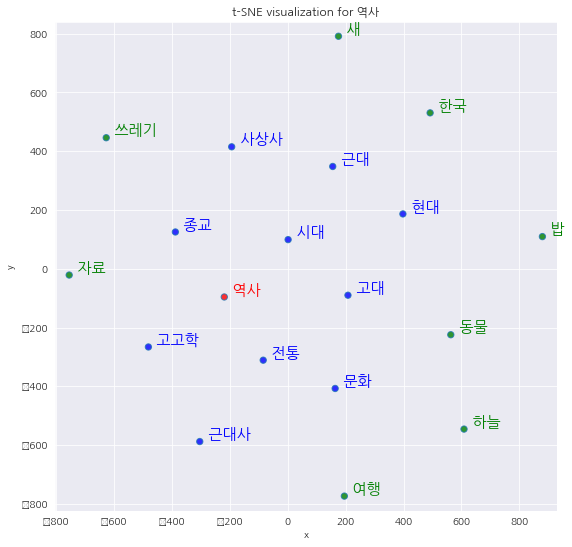

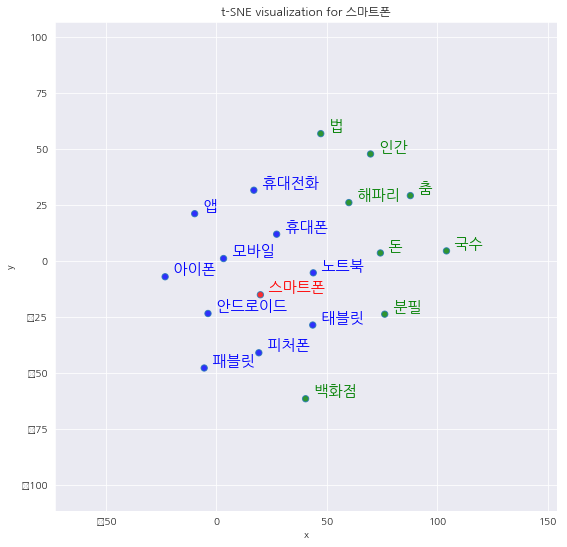

In [89]:
##한글 폰트가 필요하다 ::우분투에 있는 나눔고딕 이용
mpl.rc('font',family='NanumGothic')
tsnescatterplot(embedding, '역사', ['동물', '새', '자료', '한국', '밥', '쓰레기', '여행', '하늘'])
tsnescatterplot(embedding, '스마트폰', ['해파리', '인간', '법', '국수', '춤', '분필', '백화점', '돈'])

#그럴듯한 결과가 나옴을 확인 가능하다.

In [11]:
model = gensim.models.Word2Vec.load("korw2v")

In [15]:
model.wv.most_similar("피아노")

[('바이올린', 0.7650117874145508),
 ('첼로', 0.6447014808654785),
 ('하프시코드', 0.6123272180557251),
 ('색소폰', 0.5831627249717712),
 ('아코디언', 0.5662407279014587),
 ('클라리넷', 0.5536226630210876),
 ('비올라', 0.5514670610427856),
 ('오르간', 0.5485320687294006),
 ('삼중주', 0.548393964767456),
 ('시타르', 0.5457025170326233)]